
### Required Packages


In [104]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import re

### Reading JSON file

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Datasets/tweets.json').T

In [51]:
pd.set_option("display.max_colwidth",400)
df.head(5)

,tweet_author,tweet_text
2013-07-18 09:39:46.071961602,Hematopoiesis News,"⚕️ Scientists conducted a Phase II study of acalabrutinib in patients with relapsed/refractory #CLL who were ibrutinib-intolerant, and found an overall response rate of 73%. \nhttps://t.co/eJ6m4QpC5P https://t.co/kuZz6ZO47r"
2013-07-17 03:40:32.173842437,"Michael Wang, MD",This phase 2 Acalabrutinib-Venetoclax (AV) trial that is still in recruitment phase will study how well venetoclax and acalabrutinib works in MCL patients who either relapsed or non-respondent to the initial therapy.\n\nhttps://t.co/gg0G9At23N
2013-07-15 15:41:16.553048065,1stOncology,#NICE backs #AstraZenecas #Calquence for #CLL https://t.co/Vb5lPDoGrA
2013-07-12 19:19:42.367813635,Toby Eyre,#acalabrutinib is a valuable option in pts intolerant to #ibrutinib. Further valuable data to help decision making in #CLL \n\nEarly View | Haematologica https://t.co/Z2kCLZaX0D
2013-07-04 12:40:34.334232586,Lymphoma Hub,NICE has recommended the use of acalabrutinib for patients with treatment-naïve chronic lymphocytic leukemia. Find out more here https://t.co/6OuJptLCIN #lymsm #lymphoma


### Data Cleaning

In [91]:
pd.set_option("display.max_colwidth",400)
df_cleaned = df.copy()
for i in range(0,len(df)):
  text = df['tweet_text'][i]
  text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', text) #Remove URLs
  text = re.sub(r'#(\S+)', r'\1', text) #Hashtags replaced with text
  text = re.sub(r'@[\S]+','', text) #Remove @text
  df_cleaned['tweet_text'][i]=text

In [92]:
df_cleaned.head(3)

,tweet_author,tweet_text
2013-07-18 09:39:46.071961602,Hematopoiesis News,"⚕️ Scientists conducted a Phase II study of acalabrutinib in patients with relapsed/refractory CLL who were ibrutinib-intolerant, and found an overall response rate of 73%. \n"
2013-07-17 03:40:32.173842437,"Michael Wang, MD",This phase 2 Acalabrutinib-Venetoclax (AV) trial that is still in recruitment phase will study how well venetoclax and acalabrutinib works in MCL patients who either relapsed or non-respondent to the initial therapy.\n\n
2013-07-15 15:41:16.553048065,1stOncology,NICE backs AstraZenecas Calquence for CLL


### Load SpaCy model

In [13]:
nlp = spacy.load("en_core_web_sm")

### Finding entities 

In [108]:
entities = []
aspects = []
descriptive_term = ''
target = ''
for i in range(0,len(df_cleaned)):
  doc = nlp(df_cleaned['tweet_text'][i])
  for token in doc:
    if (token.dep_ == 'nsubj' or token.dep_ == 'nsubjpass') and (token.pos_ == 'NOUN' or token.pos_ == 'PROPN'):
      target = token.text
    if token.pos_ == 'ADJ':
      prepend = ''
      for child in token.children:
        if child.pos_ != 'ADV':
          continue
        prepend += child.text + ' '
      descriptive_term = prepend + token.text
  aspects.append({'aspect': target,'description': descriptive_term})
  entities.append(target)

In [109]:
aspects[:10]

[{'aspect': 'Scientists', 'description': 'overall'},
 {'aspect': 'venetoclax', 'description': 'initial'},
 {'aspect': 'NICE', 'description': 'initial'},
 {'aspect': 'acalabrutinib', 'description': 'Early'},
 {'aspect': 'NICE', 'description': 'lymphocytic'},
 {'aspect': 'NICE', 'description': 'lymphocytic'},
 {'aspect': 'decisions', 'description': 'More'},
 {'aspect': 'AstraZeneca', 'description': 'lymphocytic'},
 {'aspect': 'Superstar', 'description': 'unsuitable'},
 {'aspect': 'drug', 'description': 'recent'}]

In [110]:
df_cleaned['entity'] = entities
df_cleaned.head(5)

,tweet_author,tweet_text,entity
2013-07-18 09:39:46.071961602,Hematopoiesis News,"⚕️ Scientists conducted a Phase II study of acalabrutinib in patients with relapsed/refractory CLL who were ibrutinib-intolerant, and found an overall response rate of 73%. \n",Scientists
2013-07-17 03:40:32.173842437,"Michael Wang, MD",This phase 2 Acalabrutinib-Venetoclax (AV) trial that is still in recruitment phase will study how well venetoclax and acalabrutinib works in MCL patients who either relapsed or non-respondent to the initial therapy.\n\n,venetoclax
2013-07-15 15:41:16.553048065,1stOncology,NICE backs AstraZenecas Calquence for CLL,NICE
2013-07-12 19:19:42.367813635,Toby Eyre,acalabrutinib is a valuable option in pts intolerant to ibrutinib. Further valuable data to help decision making in CLL \n\nEarly View | Haematologica,acalabrutinib
2013-07-04 12:40:34.334232586,Lymphoma Hub,NICE has recommended the use of acalabrutinib for patients with treatment-naïve chronic lymphocytic leukemia. Find out more here lymsm lymphoma,NICE


### Objective 1 : Most frequent entities

In [113]:
frequency = df_cleaned['entity'].value_counts()
df_frequency = pd.DataFrame(frequency)
df_frequency.to_csv('/content/drive/MyDrive/Datasets/objective1.csv')

In [115]:
df_frequency_10 = pd.DataFrame(frequency[:10])
df_frequency_10 = df_frequency_10.reset_index()
df_frequency_10.columns = ['entity','frequency']
df_frequency_10

,entity,frequency
0,FDA,1402
1,CLL,1319
2,leukemia,1265
3,patients,910
4,trial,775
5,Acalabrutinib,580
6,Calquence,572
7,Venetoclax,516
8,AstraZeneca,482
9,Patients,344


<BarContainer object of 10 artists>

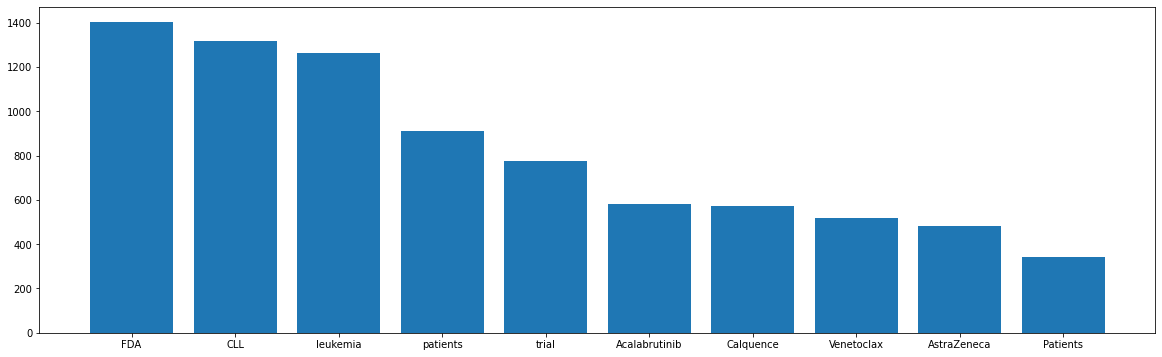

In [117]:
plt.figure(figsize=(20,6))
plt.bar('entity','frequency',data=df_frequency_10)

### Finding sentiment score(polarity)

In [118]:
sentiment_score = []
for aspect in aspects:
  score = TextBlob(aspect['description']).sentiment.polarity
  sentiment_score.append(score)

In [119]:
sentiment_score[:10]

[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0]

In [133]:
df_cleaned['sentiment_score'] = sentiment_score
df_cleaned.head()

,tweet_author,tweet_text,entity,sentiment_score
2013-07-18 09:39:46.071961602,Hematopoiesis News,"⚕️ Scientists conducted a Phase II study of acalabrutinib in patients with relapsed/refractory CLL who were ibrutinib-intolerant, and found an overall response rate of 73%. \n",Scientists,0.0
2013-07-17 03:40:32.173842437,"Michael Wang, MD",This phase 2 Acalabrutinib-Venetoclax (AV) trial that is still in recruitment phase will study how well venetoclax and acalabrutinib works in MCL patients who either relapsed or non-respondent to the initial therapy.\n\n,venetoclax,0.0
2013-07-15 15:41:16.553048065,1stOncology,NICE backs AstraZenecas Calquence for CLL,NICE,0.0
2013-07-12 19:19:42.367813635,Toby Eyre,acalabrutinib is a valuable option in pts intolerant to ibrutinib. Further valuable data to help decision making in CLL \n\nEarly View | Haematologica,acalabrutinib,0.1
2013-07-04 12:40:34.334232586,Lymphoma Hub,NICE has recommended the use of acalabrutinib for patients with treatment-naïve chronic lymphocytic leukemia. Find out more here lymsm lymphoma,NICE,0.0


### Labeling the sentiment scores

In [124]:
sentiment_label = []
for i in range(0,len(df_cleaned)):
  if df_cleaned['sentiment_score'][i] < 0:
    sentiment_label.append('Negative')
  elif df_cleaned['sentiment_score'][i] == 0:
    sentiment_label.append('Neutral')
  else:
    sentiment_label.append('Positive')

In [126]:
sentiment_label[:10]

['Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral']

### Objective 2 : Sentiments of authors towards respective entities

In [136]:
df_sentiment = df_cleaned.copy()
df_sentiment['sentiment_label'] = sentiment_label
df_sentiment.head(5)

,tweet_author,tweet_text,entity,sentiment_score,sentiment_label
2013-07-18 09:39:46.071961602,Hematopoiesis News,"⚕️ Scientists conducted a Phase II study of acalabrutinib in patients with relapsed/refractory CLL who were ibrutinib-intolerant, and found an overall response rate of 73%. \n",Scientists,0.0,Neutral
2013-07-17 03:40:32.173842437,"Michael Wang, MD",This phase 2 Acalabrutinib-Venetoclax (AV) trial that is still in recruitment phase will study how well venetoclax and acalabrutinib works in MCL patients who either relapsed or non-respondent to the initial therapy.\n\n,venetoclax,0.0,Neutral
2013-07-15 15:41:16.553048065,1stOncology,NICE backs AstraZenecas Calquence for CLL,NICE,0.0,Neutral
2013-07-12 19:19:42.367813635,Toby Eyre,acalabrutinib is a valuable option in pts intolerant to ibrutinib. Further valuable data to help decision making in CLL \n\nEarly View | Haematologica,acalabrutinib,0.1,Positive
2013-07-04 12:40:34.334232586,Lymphoma Hub,NICE has recommended the use of acalabrutinib for patients with treatment-naïve chronic lymphocytic leukemia. Find out more here lymsm lymphoma,NICE,0.0,Neutral


In [144]:
objective2 = pd.DataFrame()
objective2['entity'] = df_sentiment['entity']
objective2['author_name'] = df_sentiment['tweet_author']
objective2['overall_polarity'] = df_sentiment['sentiment_label']
objective2 = objective2.set_index(pd.Index([i for i in range(0,len(objective2))]))
objective2.head()

,entity,author_name,overall_polarity
0,Scientists,Hematopoiesis News,Neutral
1,venetoclax,"Michael Wang, MD",Neutral
2,NICE,1stOncology,Neutral
3,acalabrutinib,Toby Eyre,Positive
4,NICE,Lymphoma Hub,Neutral


In [145]:
objective2.to_csv('/content/drive/MyDrive/Datasets/objective2.csv')